# Classification de Tickets de Support Client

Ce notebook présente un pipeline complet pour la classification automatique des types de tickets de support client. Nous utilisons un modèle de machine learning basé sur TF-IDF et un réseau de neurones (MLPClassifier) pour prédire le type d'un ticket à partir de son sujet et corps.

## Objectifs
- Charger et préparer un dataset de tickets de support depuis Hugging Face.
- Prétraiter les données textuelles.
- Entraîner un modèle de classification avec un réseau de neurones.
- Évaluer les performances du modèle.
- Sauvegarder et recharger le modèle pour des prédictions sur de nouveaux tickets.

## Technologies utilisées
- **Datasets** : Pour charger le dataset Hugging Face.
- **Pandas** : Pour la manipulation des données.
- **Scikit-learn** : Pour le preprocessing (TF-IDF), le modèle (MLPClassifier), et l'évaluation.
- **Joblib** : Pour la sauvegarde et le chargement du modèle.

## Étapes du pipeline
1. Installation et imports des bibliothèques.
2. Chargement du dataset.
3. Préparation des données (DataFrame, création du texte combiné).
4. Encodage des labels et division train/test.
5. Définition du pipeline TF-IDF + MLPClassifier.
6. Entraînement du modèle.
7. Évaluation sur le jeu de test.
8. Sauvegarde du modèle.
9. Exemple de prédiction sur un nouveau ticket.

## Installation et Imports

Dans cette section, nous installons et importons toutes les bibliothèques nécessaires pour ce projet. Assurez-vous d'avoir un environnement Python configuré avec les dépendances listées dans `requirements.txt`.

- `datasets` : Bibliothèque Hugging Face pour charger des datasets.
- `pandas` : Pour la manipulation de données tabulaires.
- `sklearn` : Modules pour le machine learning (modèle, preprocessing, évaluation).
- `joblib` : Pour la sérialisation des modèles.

In [24]:
# Import des bibliothèques nécessaires
from datasets import load_dataset  # Pour charger le dataset Hugging Face
import pandas as pd  # Manipulation de données
import matplotlib.pyplot as plt
import seaborn as sns
# Imports pour le machine learning
from sklearn.model_selection import train_test_split  # Division des données
from sklearn.feature_extraction.text import TfidfVectorizer  # Vectorisation TF-IDF
from sklearn.neural_network import MLPClassifier  # Modèle de réseau de neurones (MLP)
from sklearn.pipeline import Pipeline  # Pipeline pour combiner les étapes
from sklearn.metrics import classification_report, confusion_matrix  # Évaluation
import joblib  # Sauvegarde du modèle

## Chargement du Dataset Hugging Face

Nous utilisons le dataset "Tobi-Bueck/customer-support-tickets" disponible sur Hugging Face. Ce dataset contient des tickets de support client avec des sujets, corps et types de tickets.

- **Source** : Hugging Face Datasets.
- **Contenu** : Tickets avec colonnes 'subject', 'body', 'type'.
- **Utilisation** : Charger le split 'train' pour l'entraînement.

In [15]:
# Charger le dataset customer-support-tickets depuis Hugging Face
dataset = load_dataset("Tobi-Bueck/customer-support-tickets")
dataset  # Afficher la structure du dataset

DatasetDict({
    train: Dataset({
        features: ['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8'],
        num_rows: 61765
    })
})

## Passage en DataFrame et Création du Texte

Nous convertissons le dataset Hugging Face en DataFrame Pandas pour une manipulation plus facile. Nous combinons le sujet et le corps du ticket en une seule colonne 'text' pour l'entrée du modèle.

- **Colonnes gardées** : 'subject', 'body', 'type'.
- **Nouvelle colonne** : 'text' = subject + " " + body.
- **Nettoyage** : Suppression des lignes avec valeurs manquantes.

In [16]:
# On suppose qu'on utilise le split "train"
df = dataset["train"].to_pandas()

# On garde les colonnes qui nous intéressent
# subject + body = texte d'entrée, type = label
df = df[["subject", "body", "type"]].dropna()

# Créer une colonne 'text' = subject + body
df["text"] = df["subject"].astype(str) + " " + df["body"].astype(str)

# Afficher un aperçu
df.head()

,subject,body,type,text
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Incident,Wesentlicher Sicherheitsvorfall Sehr geehrtes ...
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...",Incident,"Account Disruption Dear Customer Support Team,..."
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Request,Query About Smart Home System Integration Feat...
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",Request,Inquiry Regarding Invoice Details Dear Custome...
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Problem,Question About Marketing Agency Software Compa...


## Encodage des Labels et Split Train/Test

Les labels (types de tickets) sont des chaînes de caractères. Nous les encodons en entiers pour le modèle. Puis, nous divisons les données en ensembles d'entraînement (80%) et de test (20%).

- **Encodage** : Création de dictionnaires label2id et id2label.
- **Stratification** : Pour maintenir la distribution des classes.
- **Random state** : Pour la reproductibilité.

In [17]:
# Encodage des labels (type) en entiers
label2id = {label: idx for idx, label in enumerate(sorted(df["type"].unique()))}
id2label = {idx: label for label, idx in label2id.items()}

df["label"] = df["type"].map(label2id)

X = df["text"].values  # Textes d'entrée
y = df["label"].values  # Labels encodés

# Split train / test (par ex. 80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test)  # Afficher les tailles

(34628, 8658)

## Définition du Pipeline TF-IDF + MLPClassifier

Nous définissons un pipeline Scikit-learn qui combine la vectorisation TF-IDF avec un classificateur de réseau de neurones (MLP : Multi-Layer Perceptron).

- **TF-IDF** : Transforme le texte en vecteurs numériques, en pondérant les termes par leur fréquence inverse dans le corpus.
- **Paramètres TF-IDF** : max_features=20000, ngram_range=(1,2), stop_words="english".
- **MLPClassifier** : Réseau de neurones feedforward avec couches cachées, adapté à la classification multi-classe. Paramètres : hidden_layer_sizes=(100, 50) pour deux couches cachées, max_iter=1000 pour convergence, random_state pour reproductibilité.

In [ ]:

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,   # pour limiter la taille, ajustable
        ngram_range=(1, 2),   # unigrams + bigrams
        stop_words="english"  
    )),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(100, 50),  # Deux couches cachées : 100 neurones puis 50
        max_iter=1000,                 # Nombre max d'itérations pour convergence
        random_state=42,               # Pour reproductibilité
        early_stopping=True,           # Arrêt précoce pour éviter le surapprentissage
        n_iter_no_change=10            # Tolérance pour early stopping
    ))
])

## Entraînement du Modèle

Nous entraînons le pipeline sur les données d'entraînement. Cette étape peut prendre quelques minutes selon la taille du dataset et les ressources disponibles.

In [20]:
# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(100, 50), max_iter=1000,
                               random_state=42))])

## Évaluation sur le Jeu de Test

Nous évaluons les performances du modèle sur les données de test non vues pendant l'entraînement. Les métriques incluent la précision, le rappel, le F1-score et la matrice de confusion.

In [21]:
# Prédire sur le jeu de test
y_pred = model.predict(X_test)

print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=[id2label[i] for i in sorted(id2label.keys())]))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

      Change       0.98      0.93      0.96       878
    Incident       0.83      0.86      0.85      3477
     Problem       0.72      0.67      0.70      1815
     Request       0.98      0.99      0.99      2488

    accuracy                           0.87      8658
   macro avg       0.88      0.87      0.87      8658
weighted avg       0.87      0.87      0.87      8658

Matrice de confusion :
[[ 819    8    6   45]
 [   4 2999  472    2]
 [   2  586 1225    2]
 [  10    6    0 2472]]


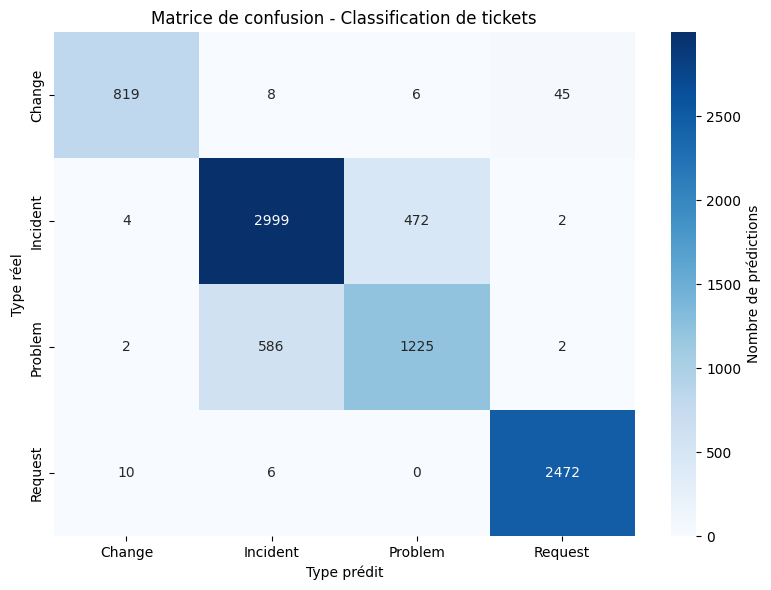

In [25]:


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in sorted(id2label.keys())],
            yticklabels=[id2label[i] for i in sorted(id2label.keys())],
            cbar_kws={'label': 'Nombre de prédictions'})
plt.xlabel('Type prédit')
plt.ylabel('Type réel')
plt.title('Matrice de confusion - Classification de tickets')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


prédictions sur le test + accuracy

In [ ]:
from sklearn.metrics import accuracy_score
# Prédictions sur le jeu de test
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy sur le jeu de test : {accuracy:.4f}")


Accuracy sur le jeu de test : 0.8680


## Sauvegarde du Modèle Entraîné

Nous sauvegardons le pipeline complet, ainsi que les mappings label2id et id2label, dans un fichier joblib pour une utilisation future.

In [27]:
# Sauvegarder tout le pipeline (TF-IDF + régression logistique)
joblib.dump({
    "pipeline": model,
    "label2id": label2id,
    "id2label": id2label
}, "ticket_type_classifier.joblib")

"Modèle sauvegardé dans ticket_type_classifier.joblib"

'Modèle sauvegardé dans ticket_type_classifier.joblib'

## Rechargement du Modèle et Prédiction sur un Nouvel Exemple

Nous rechargeons le modèle sauvegardé et testons une prédiction sur un exemple de ticket fictif pour démontrer l'utilisation en production.

In [28]:
# Recharger le modèle sauvegardé
saved = joblib.load("ticket_type_classifier.joblib")
loaded_model = saved["pipeline"]
id2label = saved["id2label"]

# Exemple de ticket
nouveau_subject = "App crashes when exporting report"
nouveau_body = (
    "Since the last update, the application closes automatically every time "
    "I try to export a PDF report for my manager."
)
nouveau_text = nouveau_subject + " " + nouveau_body

# Prédiction
pred_label_id = loaded_model.predict([nouveau_text])[0]
pred_label = id2label[pred_label_id]

print("Texte :", nouveau_text)
print("Type prédit :", pred_label) ##

Texte : App crashes when exporting report Since the last update, the application closes automatically every time I try to export a PDF report for my manager.
Type prédit : Problem


## Conclusion

Ce notebook démontre un pipeline complet pour la classification de tickets de support client utilisant TF-IDF et un réseau de neurones (MLPClassifier). Le modèle peut être utilisé pour automatiser le tri des tickets entrants dans un système de support.

### Améliorations Possibles
- **Modèles plus avancés** : Essayer des transformers comme BERT pour de meilleures performances sur le texte.
- **Preprocessing** : Ajouter du nettoyage de texte (lemmatisation, suppression de ponctuation).
- **Évaluation** : Utiliser la validation croisée pour une évaluation plus robuste.
- **Déploiement** : Intégrer le modèle dans une API Flask ou FastAPI pour un usage en production.

### Ressources
- Dataset : [Hugging Face - customer-support-tickets](https://huggingface.co/datasets/Tobi-Bueck/customer-support-tickets)
- Scikit-learn Documentation : [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)